### CDS NYU
### DS-GA 3001 | Reinforcement Learning
### Lab 02
### February 06, 2025


# Multi-Armed Bandits (MAB)

<br>

---

## Section Leader


Akshitha Kumbam – ak11071@nyu.edu

Kushagra Khatwani – kk5395@nyu.edu

## Goal of Today's Lab 

In this Lab, we will implement a special case of RL agent called "Multi-Armed Bandits", which explores different possible actions in a single, given state, and learns and exploits its learning to maximize the expected reward on the long term.

We will not build Gym environments today, and focus on building an MAB agent learning to make decisions in the simple case of a single-state environment. We will build the entire agent-environment interface from scratch.  We will return to Gym environments in future labs when we develop non-MAB agent learning sequential decisions in multi-state environments.

The simple case of MAB deals with the key reinforcement learning challenge of exploration vs. exploitation. The MAB agent needs to explore the outcome of different possible actions to learn, but it also needs to exploit its learning to make optimal decisions.


## Resources

* https://gymnasium.farama.org/


# 1. MAB with $\epsilon$-greedy policy exploration

Consider the following learning problem. You are faced repeatedly with a choice among $k$ different options, or actions. After each choice you receive a reward signal in the form of a numerical value, where the larger value is the better. Your objective is to maximize the expected total reward over some time period, for example, over 1000 action selections, or time steps.

This is the original form of the k-armed bandit problem. This name derives from the colloquial name for a slot machine, the "one-armed bandit", because it has the one lever to pull, and it is often rigged to take more money than it pays out over time. The multi-armed bandit extension is to imagine, for instance, that you are faced with multiple slot machines that you can play, but only one at a time. Which machine should you play, i.e., which arm should you pull, at any given time to maximize your total payout.

<img alt="MultiArmedBandit" width="625" height="269" src="https://github.com/NeuromatchAcademy/course-content/blob/main/tutorials/static/W3D4_Tutorial2_MultiarmedBandit.png?raw=true">

While there are many different levels of sophistication and assumptions in how the rewards are determined, we will consider here the simple scenario where each action results in a reward drawn from a different Gaussian distribution with unknown mean and unit variance. Since each action is associated with a different mean reward, the goal of the agent is to find the action with highest mean. But since the rewards are noisy (the corresponding Gaussians have unit variance), those means cannot be determined from a single observed reward. 

This problem setting is referred to as the *environment*. We will solve this *optimization problem* with an *agent*, in this case an algorithm that takes in rewards and returns actions.

### Q-value action selection in MAB

The first thing our agent needs to be able to do is choose which arm to pull. The strategy for choosing actions based on our expectations is called a *policy* (often denoted $\pi$). We could have a random policy -- just pick an arm at random each time -- though this doesn't seem likely to be capable of optimizing our reward. We want some intentionality, and to do that we need a way of describing our beliefs about the arms' reward potential. We do this with an action-value function

\begin{equation}
q(a) = \mathbb{E} [r_{t} | a_{t} = a]
\end{equation}

where the value $q$ for taking action $a \in A$ at time $t$ is equal to the expected value of the reward $r_t$ given that we took action $a$ at that time. In practice, this is often represented as an array of values (a *lookup table*), where each action's value is a different element in the array.

Great, now that we have a way to describe our beliefs about the values each action should return, let's come up with a policy.

An obvious choice would be to take the action with the highest expected value. This is referred to as the *greedy* policy

\begin{equation}
a_{t} = \underset{a}{\operatorname{argmax}} \; q_{t} (a)
\end{equation}

where our choice action is the one that maximizes the current value function.

So far so good, but it can't be this easy. And, in fact, the greedy policy does have a fatal flaw: it easily gets trapped in local maxima. It never explores to see what it hasn't seen before if one option is already better than the others. This leads us to a fundamental challenge in coming up with effective policies.

### The Exploitation-Exploration dilemma

If we never try anything new, if we always stick to the safe bet, we don't know what we are missing. Sometimes we aren't missing much of anything, and regret not sticking with our preferred choice, yet other times we stumble upon something new that was way better than we thought.

This is the exploitation-exploration dilemma: do you go with your best choice now, or risk the less certain option with the hope of finding something better. Too much exploration, however, means you may end up with a sub-optimal reward once it's time to stop.

In order to avoid getting stuck in local minima while also maximizing reward, effective policies need some way to balance between these two aims.

A simple extension to our greedy policy is to add some randomness. For instance, a coin flip -- heads we take the best choice now, tails we pick one at random. This is referred to as the $\epsilon$-greedy policy:

\begin{equation}
P (a_{t} = a) = 
        \begin{cases}
        1 - \epsilon + \epsilon/N    & \quad \text{if } a_{t} = \underset{a}{\operatorname{argmax}}  \; q_{t} (a) \\
        \epsilon/N        & \quad \text{else} 
        \end{cases} 
\end{equation}

which is to say that with probability 1 - $\epsilon$ for $\epsilon \in [0,1]$ we select the greedy choice, and otherwise we select an action at random (including the greedy option).

Despite its relative simplicity, the epsilon-greedy policy is quite effective, which leads to its general popularity.

## Define custom plotting functions we will use for this case study

In [1]:
!pip install ipywidgets


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets  # interactive display

%config InlineBackend.figure_format = 'retina'
#plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

np.set_printoptions(precision=3)

def plot_choices(q, epsilon, choice_fn, n_steps=1000, rng_seed=1):
  np.random.seed(rng_seed)
  counts = np.zeros_like(q)
  for t in range(n_steps):
    action = choice_fn(q, epsilon)
    counts[action] += 1

  fig, ax = plt.subplots()
  ax.bar(range(len(q)), counts/n_steps)
  ax.set(ylabel='% chosen', xlabel='action', ylim=(0,1), xticks=range(len(q)))


def plot_multi_armed_bandit_results(results):
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 4))
  ax1.plot(results['rewards'])
  ax1.set(title=f"Total Reward: {np.sum(results['rewards']):.2f}",
          xlabel='step', ylabel='reward')
  ax2.plot(results['qs'])
  ax2.set(xlabel='step', ylabel='value')
  ax2.legend(range(len(results['mu'])))
  ax3.plot(results['mu'], label='latent')
  ax3.plot(results['qs'][-1], label='learned')
  ax3.set(xlabel='action', ylabel='value')
  ax3.legend()


def plot_parameter_performance(labels, fixed, trial_rewards, trial_optimal):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

  ax1.plot(np.mean(trial_rewards, axis=1).T)
  ax1.set(title=f'Average Reward ({fixed})', xlabel='step', ylabel='reward')
  ax1.legend(labels)

  ax2.plot(np.mean(trial_optimal, axis=1).T)
  ax2.set(title=f'Performance ({fixed})', xlabel='step', ylabel='% optimal')
  ax2.legend(labels)

## Implement an $\epsilon$-greedy policy

In this exercise you will implement the epsilon-greedy algorithm for deciding which action to take from a set of possible actions given their value function and a probability $\epsilon$ of simply choosing one at random. 


findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd S

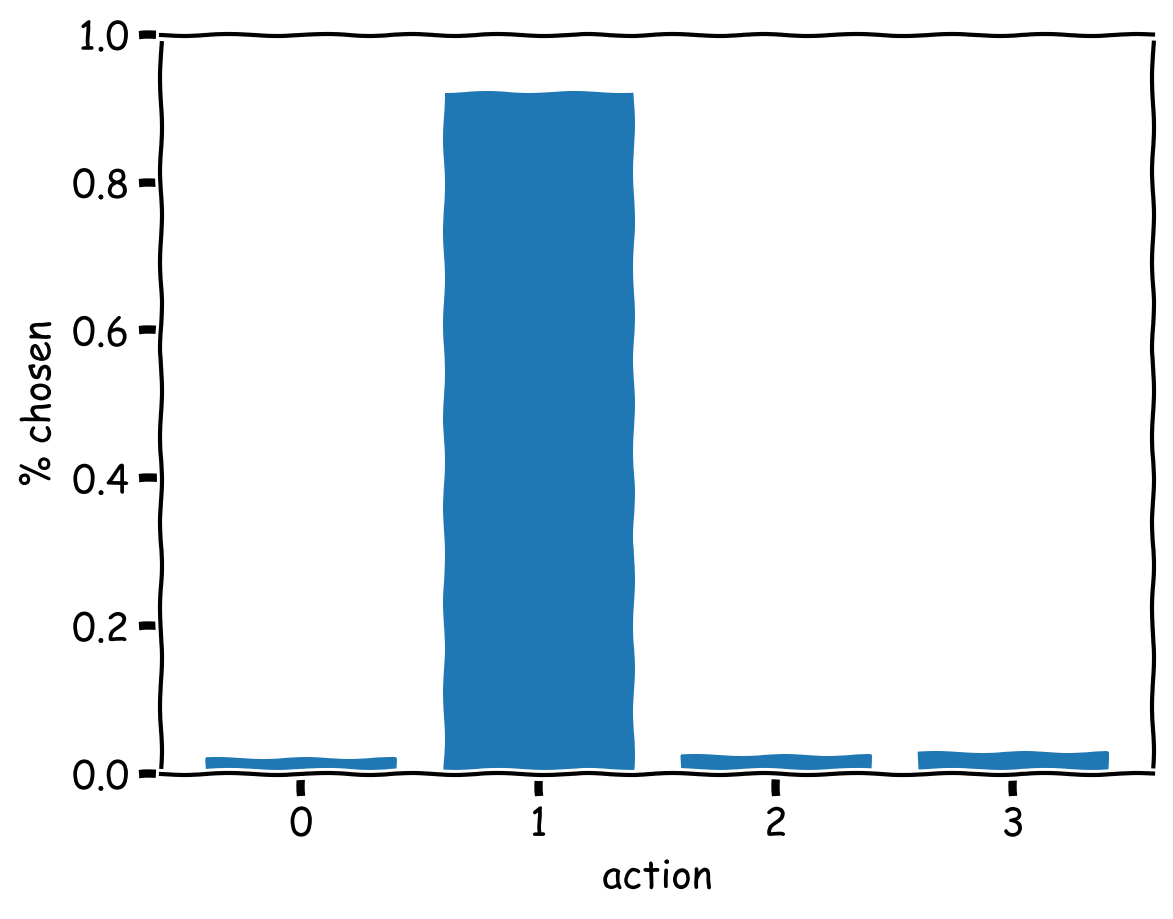

In [2]:
def epsilon_greedy(q, epsilon):

    """
      Epsilon-greedy policy: selects the maximum value action with probability
      (1-epsilon) and selects randomly with epsilon probability.

      Args:
        q (ndarray): an array of action values
        epsilon (float): probability of selecting an action randomly

      Returns:
        int: the chosen action
    """
    
    # write a boolean expression that determines if we should take the best action
    be_greedy = np.random.rand() > epsilon

    if be_greedy:
        # write an expression for selecting the best action from the action values
        action = np.argmax(q)
    else:
        # write an expression for selecting a random action
        action = np.random.choice(range(len(q)))
        
    return action

# Initialize parameters
q = [-2, 5, 0, 1]
epsilon = 0.1

# Visualize
with plt.xkcd():
    plot_choices(q, epsilon, epsilon_greedy)

**Here is the output to expect:**

<img alt='' align='left' width=827.0 height=540.0 src=./figure1.png>



This is what we should expect, that the action with the largest value (action 1) is selected about (1-$\epsilon$) of the time, or 90% for $\epsilon = 0.1$, and the remaining 10% is split evenly amongst the other options. Use the demo below to explore how changing $\epsilon$ affects the distribution of selected actions.

## [optional] Vizualize different $\epsilon$ schedules

Epsilon is our one parameter for balancing exploitation and exploration.  Given a set of values $q = [-2, 5, 0, 1]$, try out different values of epsilon to see how changing $\epsilon$ influences our selection of the max value 5 (action = 1) vs the others. 

At the extremes of its range (0 and 1), the $\epsilon$-greedy policy reproduces two other policies. What are they?

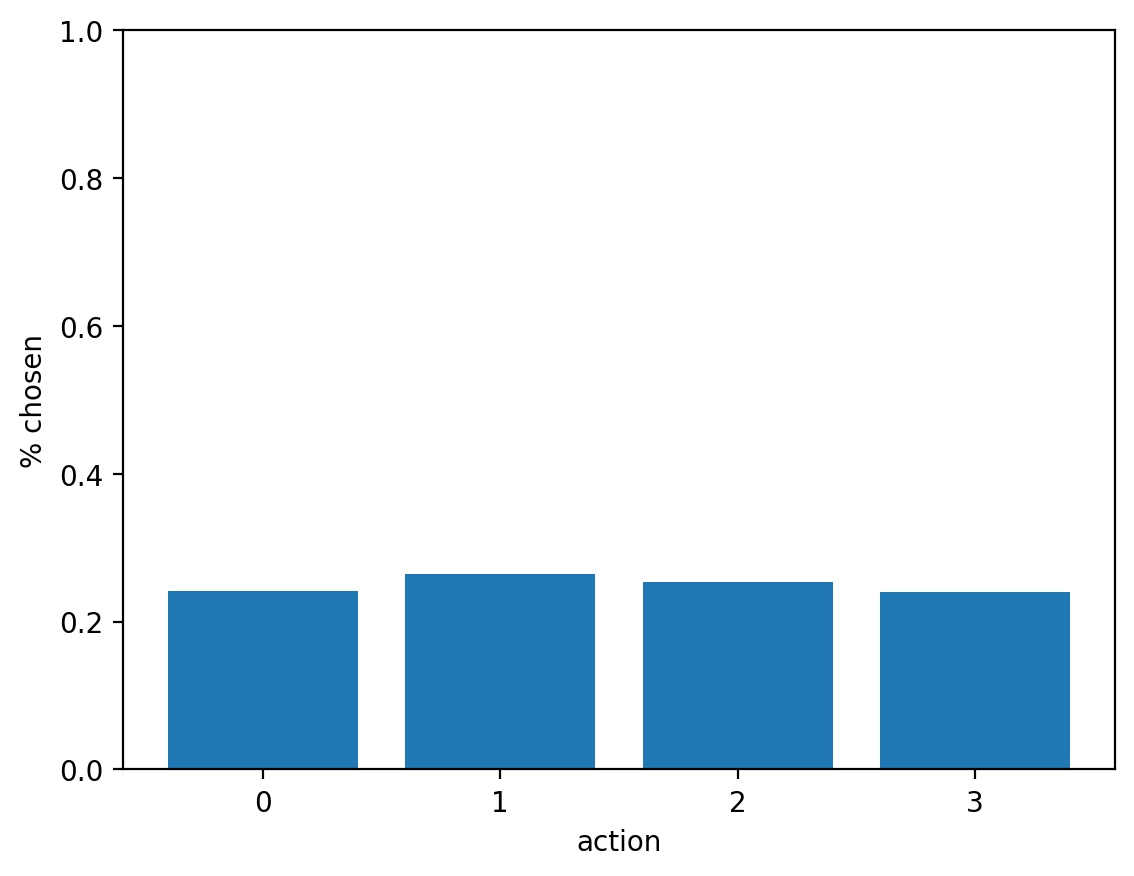

In [7]:
#Change the value of epsilon to observe how our agent's behaviour changes.
epsilon = 1
q = [-2, 5, 0, 1]
plot_choices(q, epsilon, epsilon_greedy, rng_seed=None)
plt.show()

**Take-away**: When $\epsilon = 0$, the agent always selects the currently best action, i.e., it becomes greedy. When $\epsilon = 1$, the agent selects actions randomly.


## Learn Q-values from sampled rewards

In this exercise you will implement an action-value update rule. The function will take in the action-value function represented as an array `q`, the action taken, the reward received, and a learning rate, `alpha`. The function will return the updated value for the selected action.

### *Refresh on the concepts covered during the lecture*:

Now that we have a policy for deciding what to do, how do we learn from our actions?

One way to do this is just keep a record of every result we ever got and use the averages for each action. If we have a potentially very long running episode, the computational cost of keeping all these values and recomputing the mean over and over again isn't ideal. Instead we can use a moving average approach:

\begin{equation}
q_{t+1}(a) \leftarrow q_{t}(a) + \frac{1}{n_t} (r_{t} - q_{t}(a))
\end{equation}

where our action-value function $q_t(a)$ is the mean of the rewards seen so far, $n_t$ is the number of actions taken by time $t$, and $r_t$ is the reward just received for taking action $a$.

The $\frac{1}{n_t}$ requires to remember how many of each action was taken, and also it attributes the same weight to every update, so in practice this ratio is often replaced by an arbitrary learning rate $\alpha$:

\begin{equation}
q_{t+1}(a) \leftarrow q_{t}(a) + \alpha (r_{t} - q_{t}(a)).
\end{equation}

In [3]:
def update_action_value(q, action, reward, alpha):
  
    """ 
      Compute the updated action value given the learning rate and observed
      reward.

      Args:
        q (ndarray): an array of action values
        action (int): the action taken
        reward (float): the reward received for taking the action
        alpha (float): the learning rate

      Returns:
        float: the updated value for the selected action
    """

    # Write an expression for the updated action value
    value = q[action] + alpha * (reward - q[action])

    return value


# Set parameters
q = [-2, 5, 0, 1]
action = 2
print(f"Original q({action}) value = {q[action]}")

# Update action
q[action] = update_action_value(q, 2, 10, 0.01)
print(f"Updated q({action}) value = {q[action]}")

Original q(2) value = 0
Updated q(2) value = 0.1


## Simulate a Multi-Armed Bandits environment (from scratch)

Now that we have both a policy and a learning rule to update q-values, we can combine these to solve the multi-armed bandit task. Recall that we have some number of arms that give rewards drawn from Gaussian distributions with unknown mean and unit variance, and our goal is to find the arm with the highest mean.

**First, let's create the environment:**

In [16]:
def multi_armed_bandit(n_arms, epsilon, alpha, n_steps):
    
    """ 
      A Gaussian multi-armed bandit using an epsilon-greedy policy. For each
      action, rewards are randomly sampled from normal distribution, with a mean
      associated with that arm and unit variance.

      Args:
        n_arms (int): number of arms or actions
        epsilon (float): probability of selecting an action randomly
        alpha (float): the learning rate
        n_steps (int): number of steps to evaluate

      Returns:
        dict: a dictionary containing the action values, actions, and rewards from
        the evaluation along with the true arm parameters mu and the optimality of
        the chosen actions.
    """
    
    # Gaussian bandit parameters
    mu = np.random.normal(size=n_arms)

    # Evaluation and reporting state
    q = np.zeros(n_arms)
    qs = np.zeros((n_steps, n_arms))
    rewards = np.zeros(n_steps)
    actions = np.zeros(n_steps)
    optimal = np.zeros(n_steps)

    # Run the bandit
    for t in range(n_steps):

        # Compute rewards for all actions (sampled from a Gaussian with mean mu)
        all_rewards = np.random.normal(mu)

        # Select an action according to an epsilon-greedy policy
        action = epsilon_greedy(q, epsilon)
        actions[t] = action

        # Observe the reward for the chosen action
        reward = all_rewards[action]
        rewards[t] = reward

        # Was it the best possible choice?
        optimal_action = np.argmax(all_rewards)
        optimal[t] = action == optimal_action

        # Update the q-value for the action selected
        q[action] = update_action_value(q, action, reward, alpha)
        qs[t] = q

    results = {
        'qs': qs,
        'actions': actions,
        'rewards': rewards,
        'mu': mu,
        'optimal': optimal
    }

    return results

In [17]:
def multi_armed_bandit_initial_q(n_arms, epsilon, init_q, alpha, n_steps):
    
    """ 
      A Gaussian multi-armed bandit using an epsilon-greedy policy. For each
      action, rewards are randomly sampled from normal distribution, with a mean
      associated with that arm and unit variance.

      Args:
        n_arms (int): number of arms or actions
        epsilon (float): probability of selecting an action randomly
        alpha (float): the learning rate
        n_steps (int): number of steps to evaluate

      Returns:
        dict: a dictionary containing the action values, actions, and rewards from
        the evaluation along with the true arm parameters mu and the optimality of
        the chosen actions.
    """
    
    # Gaussian bandit parameters (0, 1)
    mu = np.random.normal(size=n_arms)

    # Evaluation and reporting state
    q = [init_q] * n_arms
    qs = np.zeros((n_steps, n_arms))
    rewards = np.zeros(n_steps)
    actions = np.zeros(n_steps)
    optimal = np.zeros(n_steps)

    # Run the bandit
    for t in range(n_steps):

        # Compute rewards for all actions (sampled from a Gaussian with mean mu, variance 1)
        all_rewards = np.random.normal(mu)

        # Select an action according to an epsilon-greedy policy
        action = epsilon_greedy(q, epsilon)
        actions[t] = action

        # Observe the reward for the chosen action
        reward = all_rewards[action]
        rewards[t] = reward

        # Was it the best possible choice?
        optimal_action = np.argmax(all_rewards)
        optimal[t] = action == optimal_action

        # Update the q-value for the action selected
        q[action] = update_action_value(q, action, reward, alpha)
        qs[t] = q

    results = {
        'qs': qs,
        'actions': actions,
        'rewards': rewards,
        'mu': mu,
        'optimal': optimal
    }

    return results

We can use our multi-armed bandit method to evaluate how our epsilon-greedy policy and learning rule perform at solving the task. First we will set our environment to have 10 arms and our agent parameters to $\epsilon=0.1$ and $\alpha=0.01$. In order to get a good sense of the agent's performance, we will run the episode for 1000 steps.

## Evaluate the learning performance


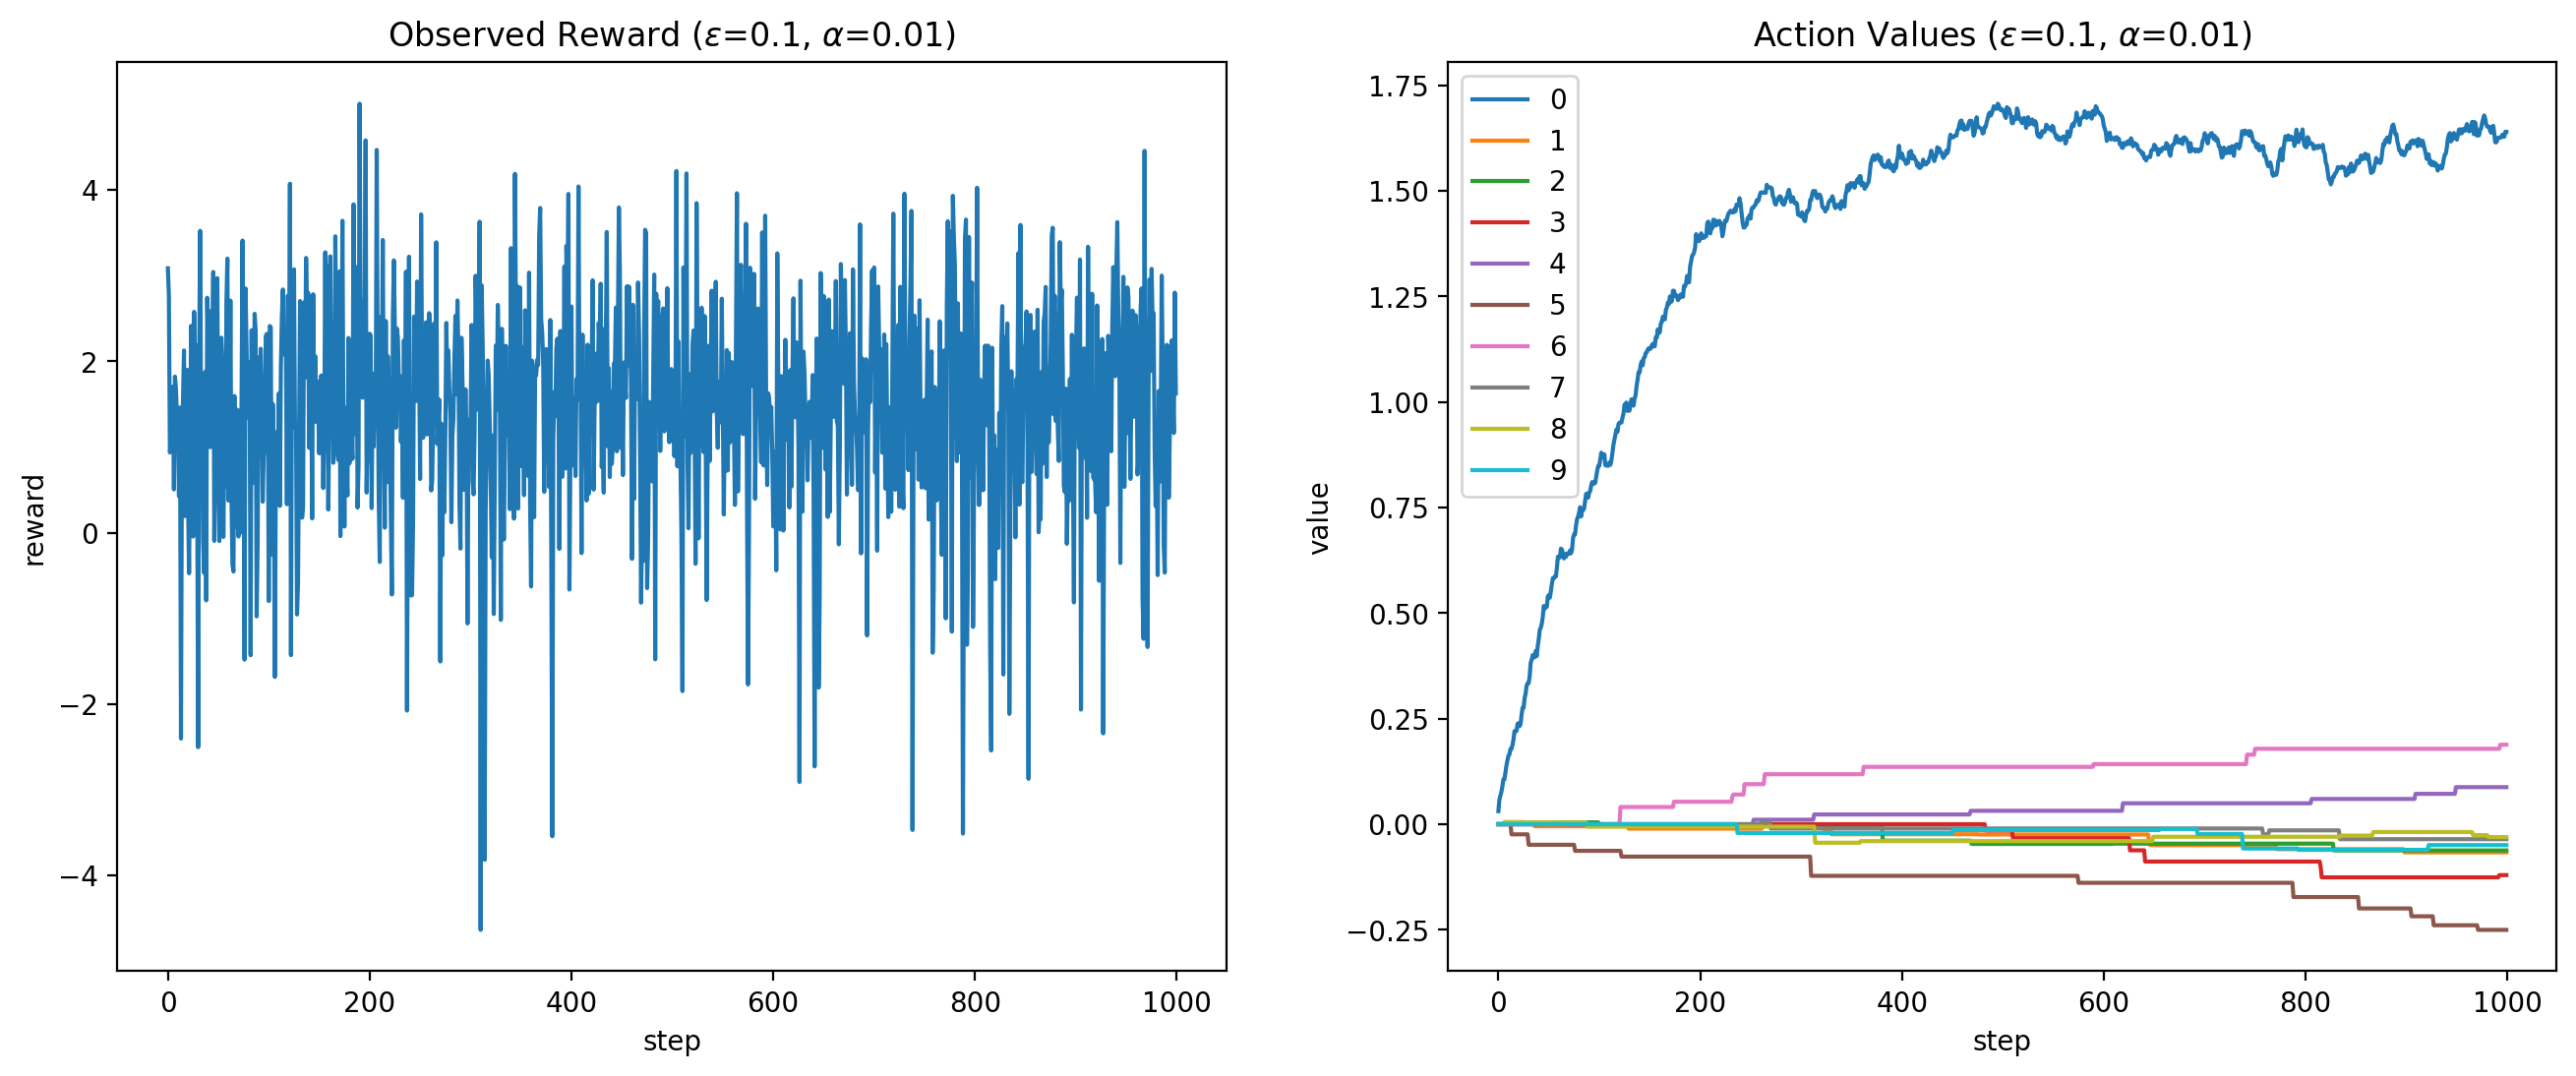

In [8]:
# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

n_arms = 10
epsilon = 0.1
alpha = 0.01
n_steps = 1000

results = multi_armed_bandit(n_arms, epsilon, alpha, n_steps)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
ax1.plot(results['rewards'])
ax1.set(title=f'Observed Reward ($\epsilon$={epsilon}, $\\alpha$={alpha})',
        xlabel='step', ylabel='reward')
ax2.plot(results['qs'])
ax2.set(title=f'Action Values ($\epsilon$={epsilon}, $\\alpha$={alpha})',
        xlabel='step', ylabel='value')
ax2.legend(range(n_arms))
plt.show()

Rewards seem all over the place (left figure), but the agent quickly settles in on the first arm (action 0) as the preferred choice of action (right figure).

Let's see how well we did at recovering the true means of the Gaussian random variables behind the arms.

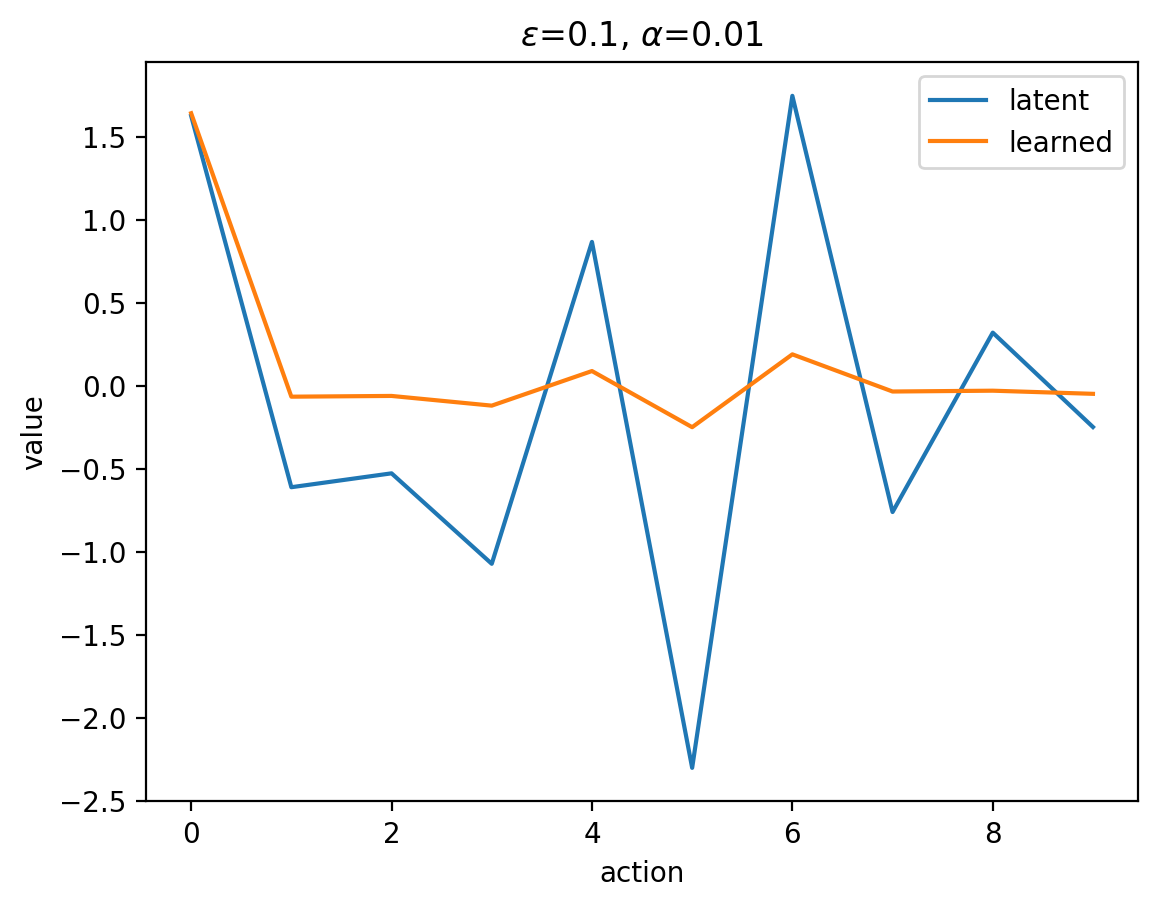

In [11]:
fig, ax = plt.subplots()
ax.plot(results['mu'], label='latent')
ax.plot(results['qs'][-1], label='learned')
ax.set(title=f'$\epsilon$={epsilon}, $\\alpha$={alpha}',
       xlabel='action', ylabel='value')
ax.legend()
plt.show()

So it appears the agent found a very good estimate for action 0, but most of the others are not great. We can see the effect of the local maxima trap at work -- the greedy part of our algorithm locked onto action 0, which is actually the 2nd best choice to action 6. These are the means of Gaussian random variables and the overlap between the two is indded quite high, so even if the agent did explore action 6, it could still draw a sample that has a lower estimated value than the estimated value for action 0.

This was just one choice of parameters. Perhaps there is a better combination?



## Benchmark different values of MAB parameters ($\epsilon$ and $\alpha$)

Change the values below to explore how varying $\epsilon$ (exploitation-exploration tradeoff), $\alpha$ (learning rate), and even the number of actions $k$, changes the behavior of the agent.

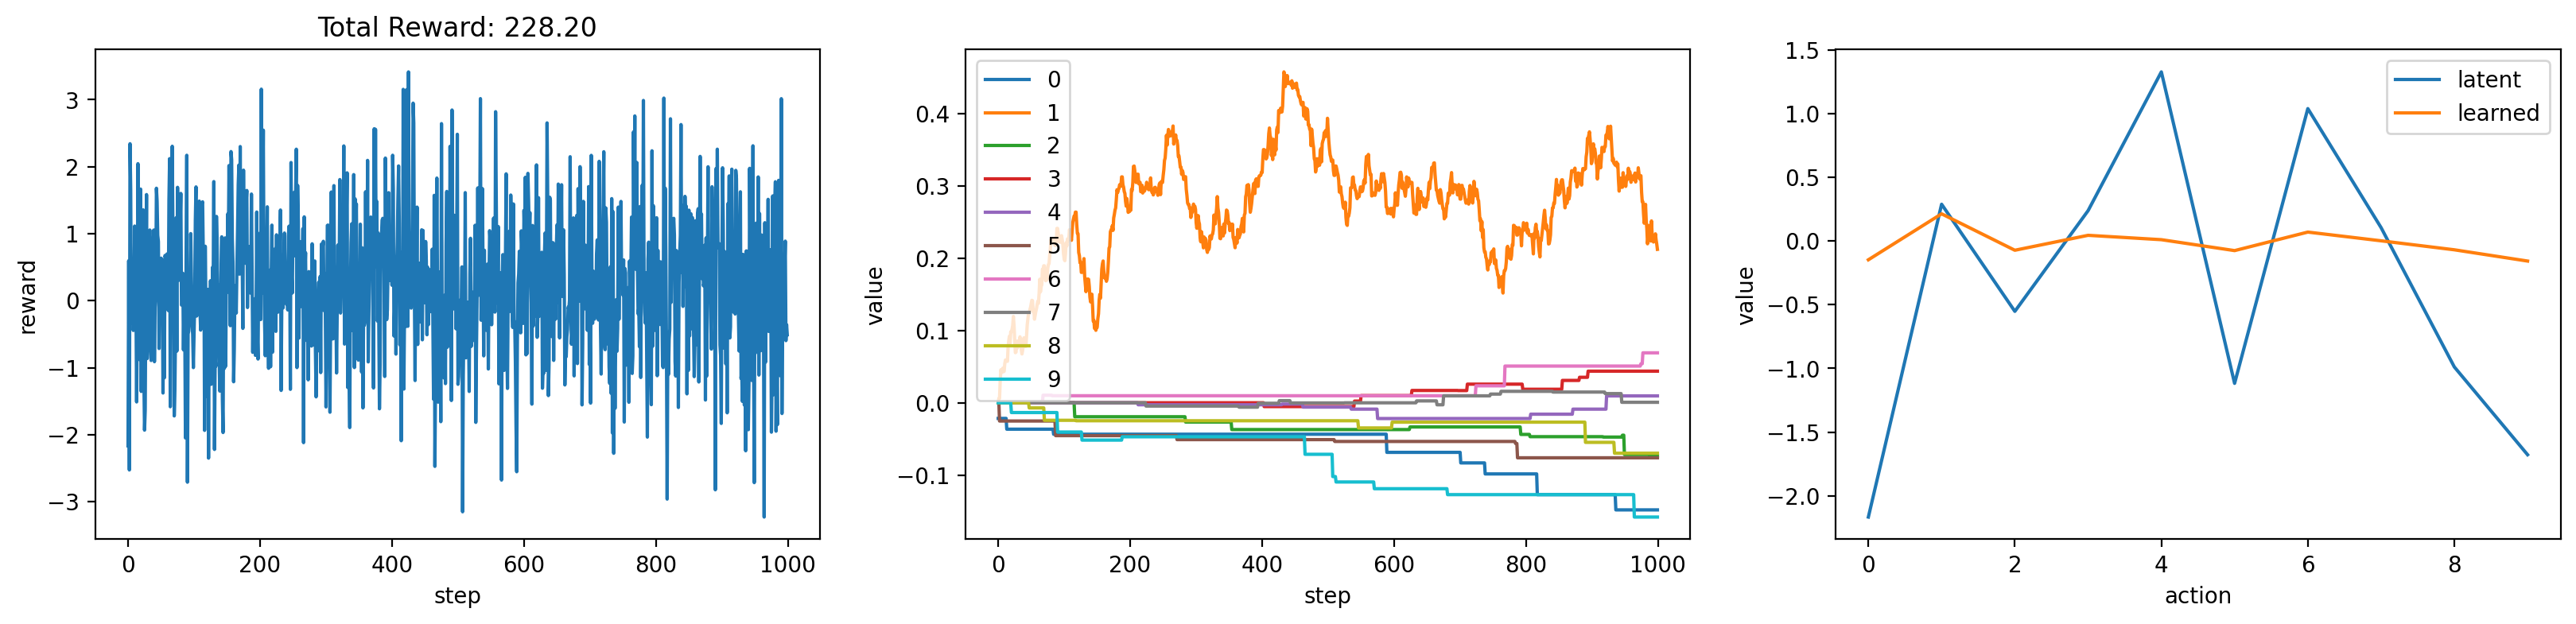

In [16]:
k = 10
epsilon = 0.1
alpha = 0.01
results = multi_armed_bandit(k, epsilon, alpha, 1000)
plot_multi_armed_bandit_results(results)
plt.show()

While we see how changing the epsilon and alpha values impact the agent's behavior, this doesn't give us a good sense of which combination is optimal. Due to the stochastic nature of both the rewards and the policy, a single trial run isn't sufficient to give us this information. Let's run multiple trials and compare the average performance.

### Benchmark different $\epsilon$ schedules

Let us look at different values of $\epsilon \in [0.0, 0.1, 0.2]$ to a fixed $\alpha=0.1$. We will run 200 trials (trying to balance speed with accuracy).

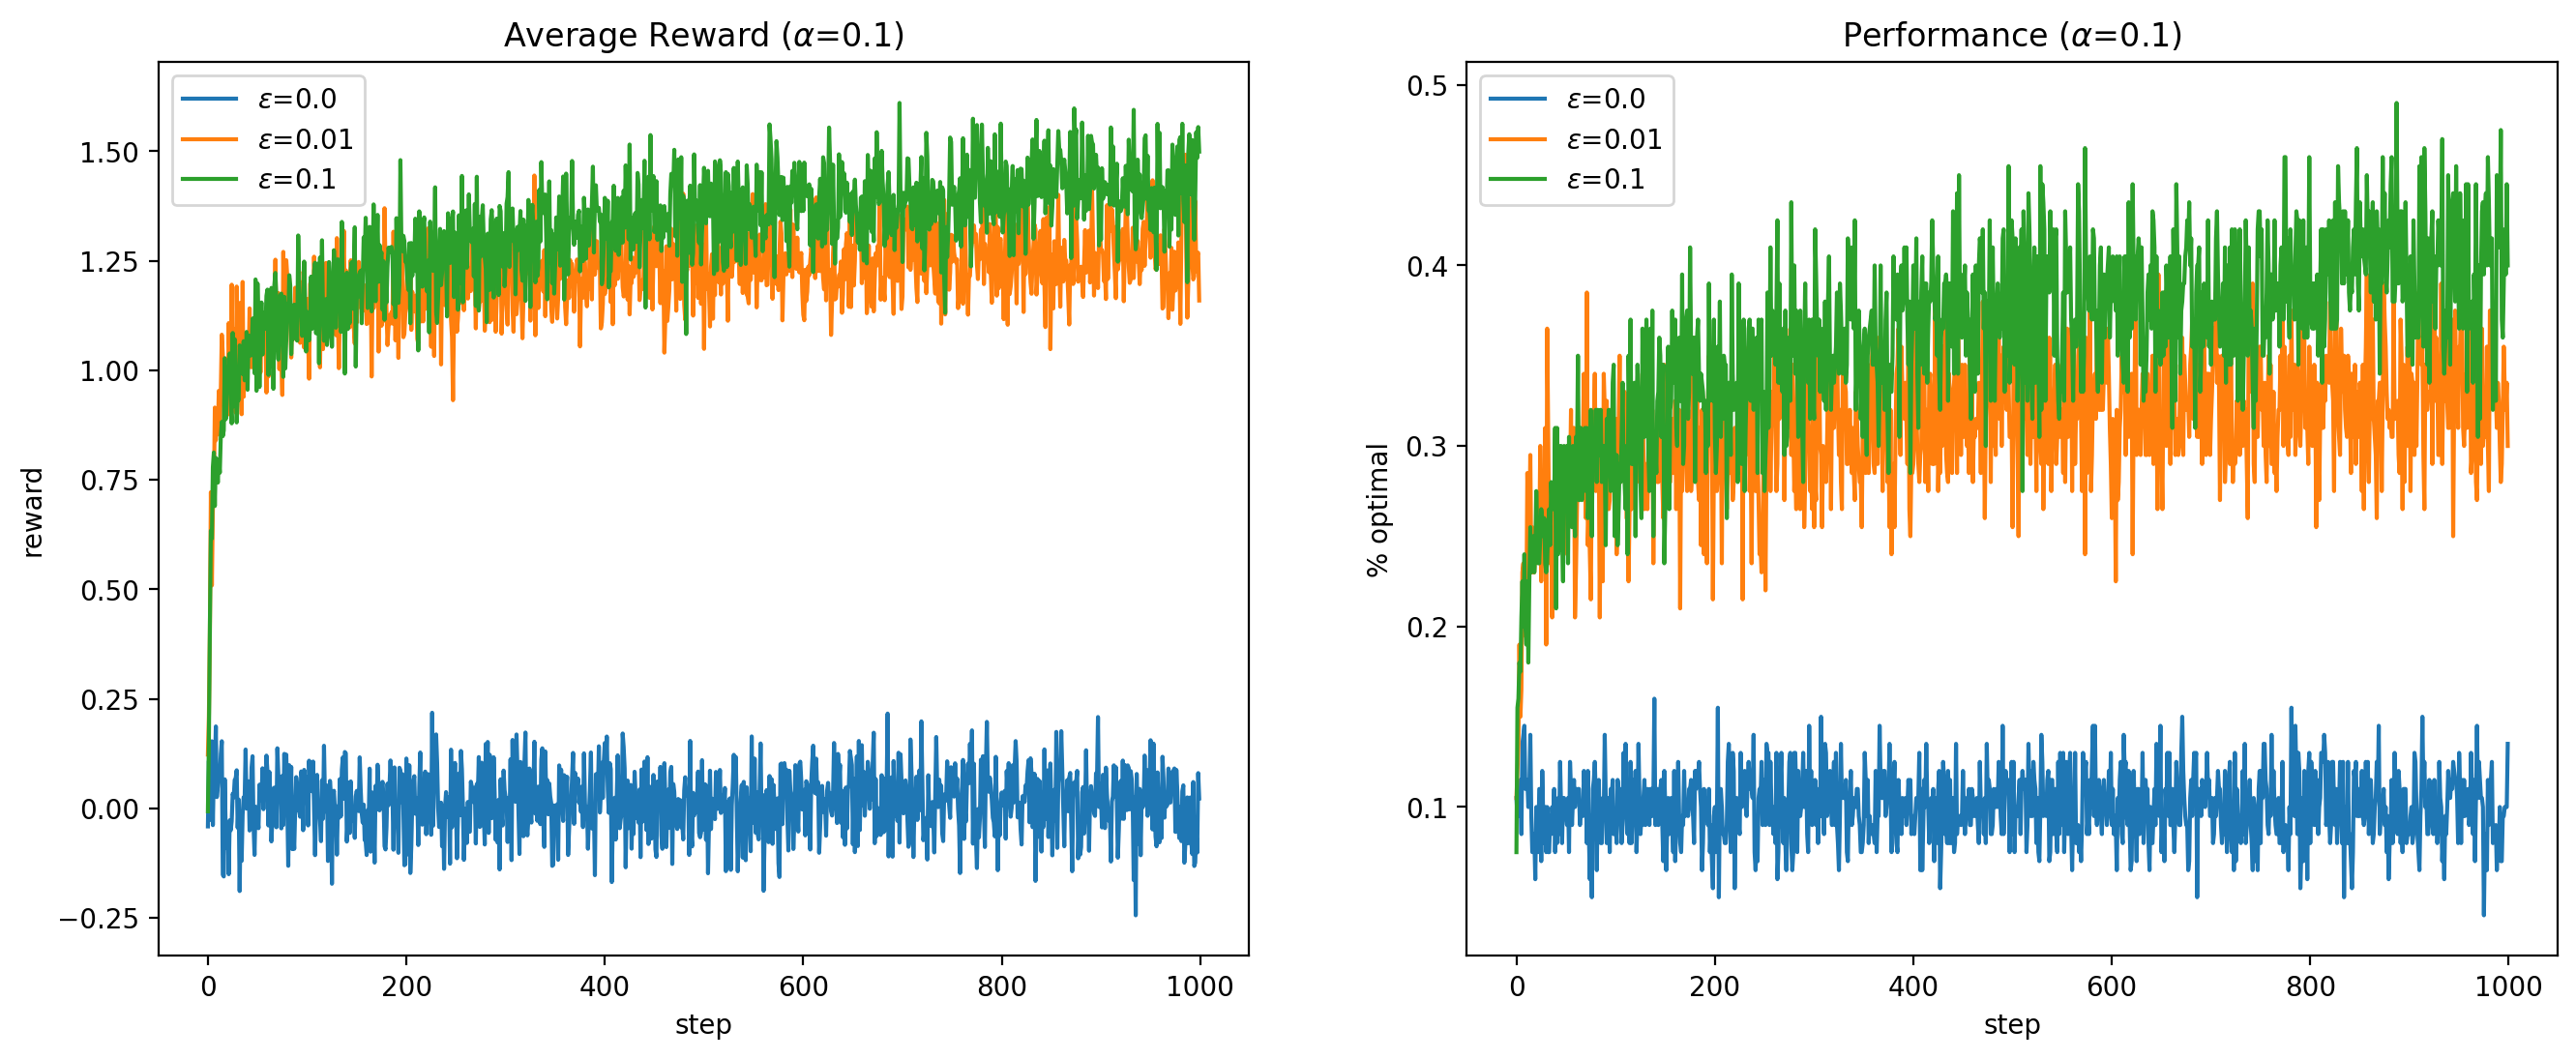

In [20]:
# Seed set for reproducibility, comment out or change seed value for different results
np.random.seed(1)

epsilons = [0.0, 0.01, 0.1]
init_qs = [-10, 0, 0]
alpha = 0.1
n_trials = 200
trial_rewards = np.zeros((len(epsilons), n_trials, n_steps))
trial_optimal = np.zeros((len(epsilons), n_trials, n_steps))
for i, epsilon in enumerate(epsilons):
    for n in range(n_trials):
        results = multi_armed_bandit_initial_q(n_arms, epsilon, init_qs[i], alpha, n_steps)
        trial_rewards[i, n] = results['rewards']
        trial_optimal[i, n] = results['optimal']

labels = [f'$\epsilon$={e}' for e in epsilons]
fixed = f'$\\alpha$={alpha}'
plot_parameter_performance(labels, fixed, trial_rewards, trial_optimal)
plt.show()

On the left we have plotted the average reward over time, and we see that while $\epsilon=0$ (the greedy policy) does well initially, $\epsilon=0.1$ starts to do slightly better in the long run, while $\epsilon=0.2$ does the worst. 

Looking on the right, we see the percentage of times the optimal action (the best possible choice at time $t$) was taken, and here again we see a similar pattern of $\epsilon=0.1$ starting out a bit slower but eventually having a slight edge in the longer run.


### Benchmark different $\alpha$ learning rates

Let us do the same for the learning rates. We will evaluate $\alpha \in [0.01, 0.1, 1.0]$ to a fixed $\epsilon=0.1$.

[[[ 3.086  2.766  0.937 ...  1.164  2.803  1.626]
  [-2.168  0.596 -2.527 ... -0.597 -0.359 -0.509]
  [-2.665  0.961 -0.485 ... -0.023  1.684  0.729]
  ...
  [-0.506 -2.876  0.674 ...  1.098  0.504 -0.346]
  [-0.505  2.353  2.762 ...  0.666  2.307 -0.042]
  [-2.627  1.205  0.055 ...  0.422  2.101  0.008]]

 [[ 0.188  2.281  0.183 ...  1.744 -0.484  2.262]
  [ 0.374 -1.01  -2.388 ... -0.658  0.631  1.326]
  [-0.992  1.767  0.262 ...  2.196 -0.868  0.954]
  ...
  [ 0.238 -1.849  1.343 ...  1.924  1.565  1.48 ]
  [ 0.23   0.547 -2.553 ...  2.474 -0.633 -1.785]
  [ 1.62   2.229  2.168 ...  2.895  1.998  1.353]]

 [[-1.562  1.347  2.04  ...  0.927 -0.512 -1.506]
  [ 2.276  1.392  1.312 ...  1.274  3.746  1.31 ]
  [ 2.104 -0.063  0.76  ...  2.495  0.618 -0.769]
  ...
  [ 0.509  0.079  0.032 ... -0.072  2.488  2.395]
  [-2.642  2.757  1.438 ...  3.89   2.398  2.269]
  [ 4.199  1.667 -0.72  ...  1.258  1.646  0.628]]]


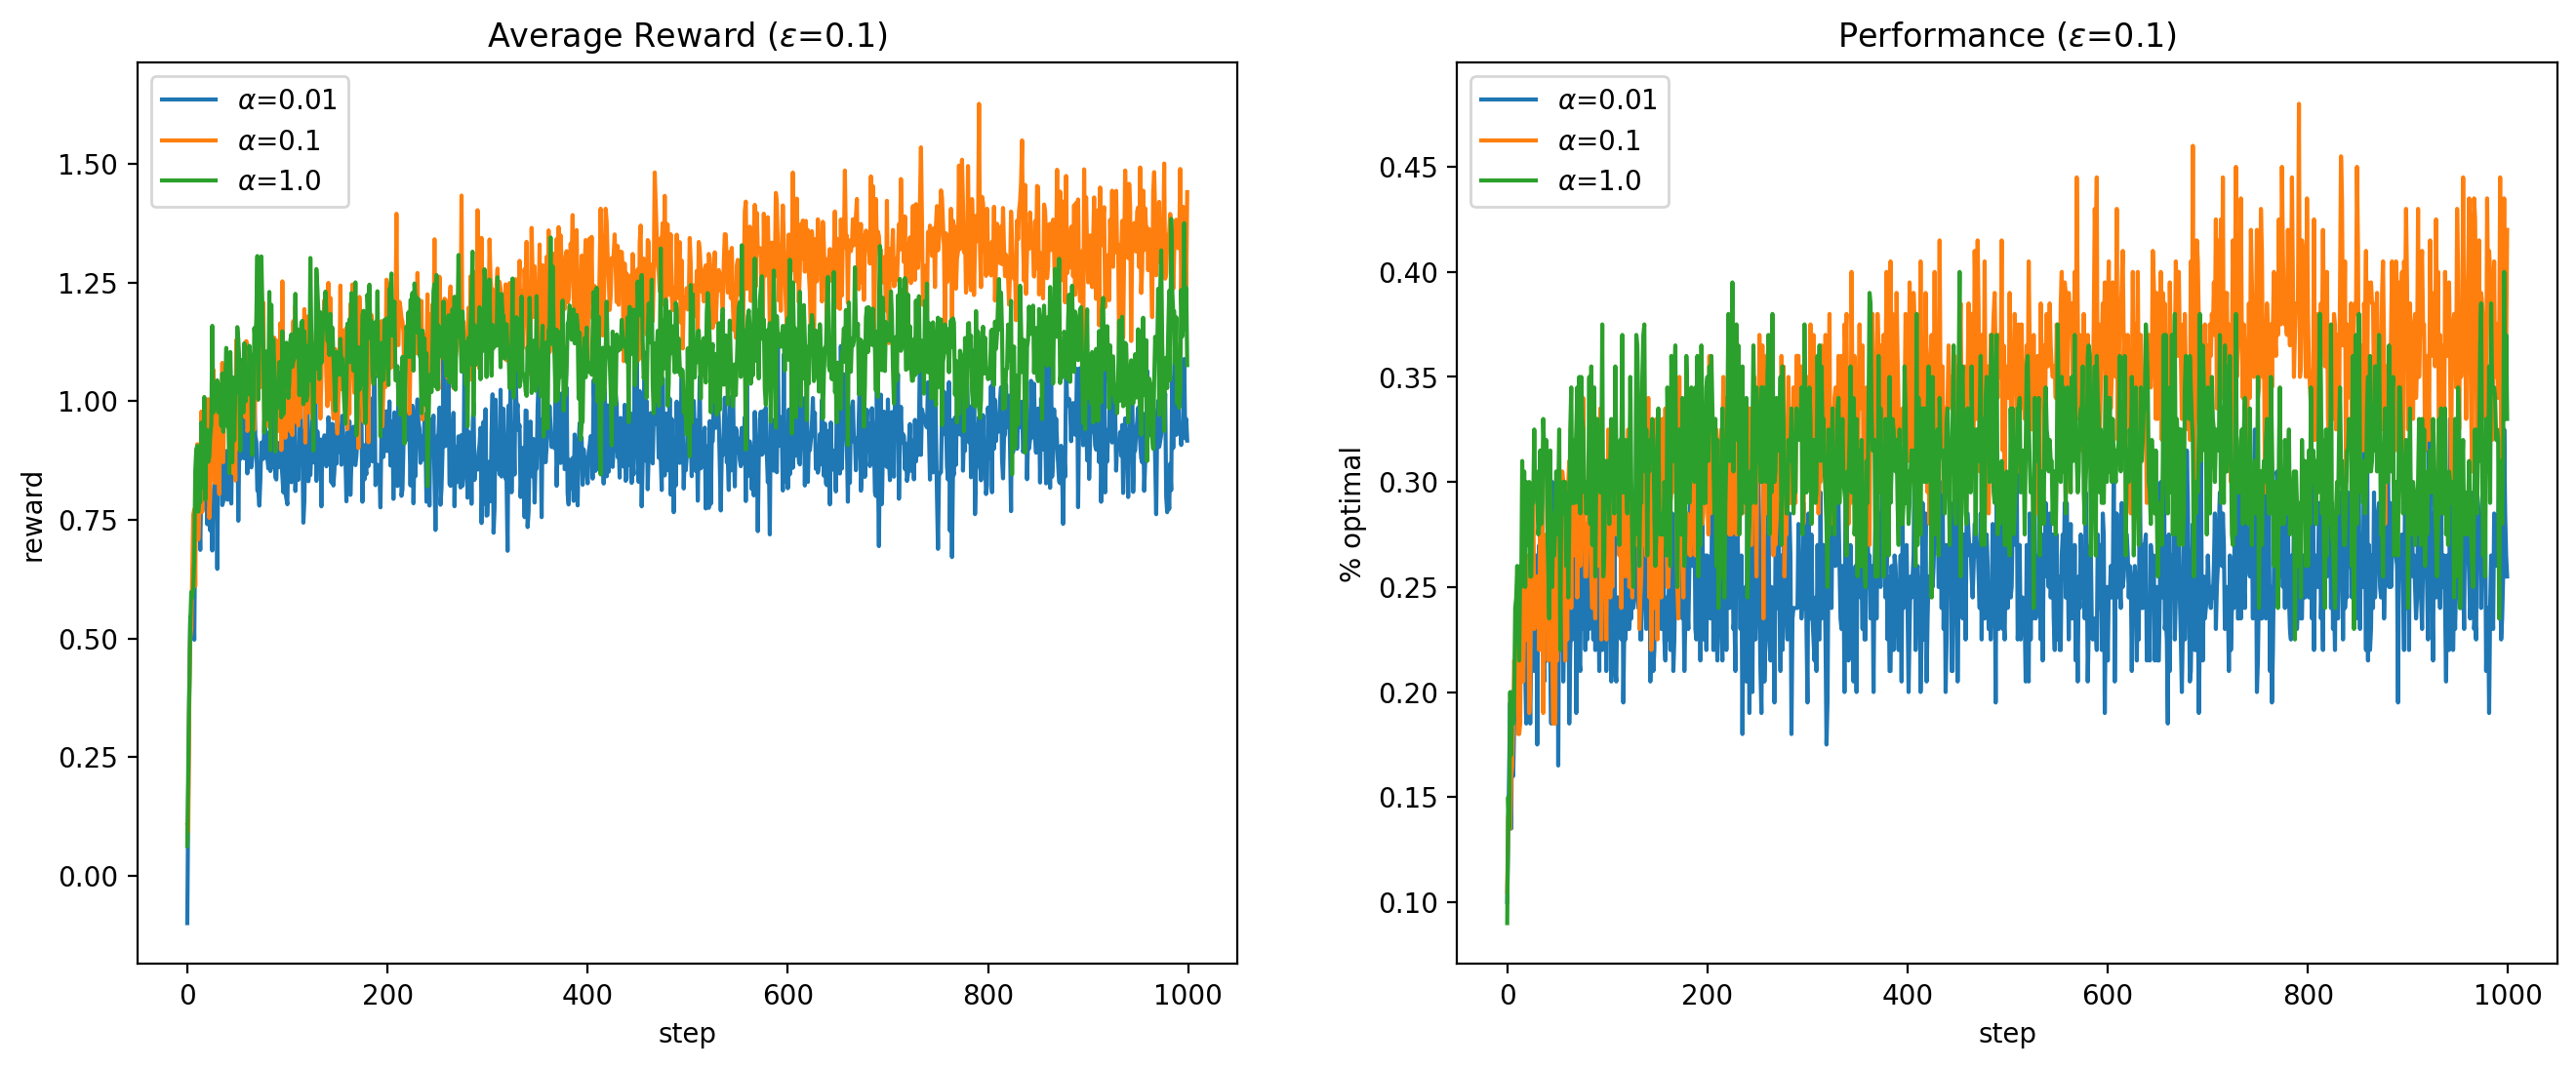

In [19]:
# Seed set for reproducibility, comment out or change seed value for different results
np.random.seed(1)

epsilon = 0.1
alphas = [0.01, 0.1, 1.0]
n_trials = 200
trial_rewards = np.zeros((len(epsilons), n_trials, n_steps))
trial_optimal = np.zeros((len(epsilons), n_trials, n_steps))
for i, alpha in enumerate(alphas):
    for n in range(n_trials):
        results = multi_armed_bandit(n_arms, epsilon, alpha, n_steps)
        trial_rewards[i, n] = results['rewards']
        trial_optimal[i, n] = results['optimal']


print(trial_rewards)
labels = [f'$\\alpha$={a}' for a in alphas]
fixed = f'$\epsilon$={epsilon}'
plot_parameter_performance(labels, fixed, trial_rewards, trial_optimal)
plt.show()

Again we see a balance is needed to find an effective learning rate. $\alpha=0.01$ is too weak to quickly incorporate good values, while $\alpha=1$ is too strong likely resulting in high variance in values due to the Gaussian nature of the rewards.

In [21]:
np.sum(trial_rewards, axis=1).shape


(3, 1000)

In [22]:
trial_rewards.shape

(3, 200, 1000)

### Summary

In this lab you implemented both the $\epsilon$-greedy decision algorithm and a learning rule for solving a multi-armed bandit scenario. You saw how balancing exploitation and exploration in action selection is critical in finding optimal solutions. You also saw how choosing an appropriate $\epsilon$-schedule and learning rate determines how well an agent can generalize the information it receives from rewards.


---

# 2. [optional] MAB with Thompson sampling policy exploration

For this case study, we will simulate 3 bandits with each an underlying probability of winning stored in `p_bandits` (unknown to the agent) . A method `pull()` will simulate the pulling of each arm" by returning if the pull was a win (1) or not (0) based on the underlying probability.


#### Python package versions originally used in this case study:
    - Python version  : 3.9.4
    - IPython version : 7.23.1
    - scipy           : 1.6.3
    - matplotlib      : 3.4.2
    - seaborn         : 0.11.1
    - numpy           : 1.20.2

In [23]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import scipy
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(42)

# Define the multi-armed bandits
nb_bandits = 3  # Number of bandits
# True probability of winning for each bandit
p_bandits = [0.45, 0.55, 0.60]

def pull(i):
    """Pull arm of bandit with index `i` and return 1 if win, 
    else return 0."""
    if np.random.rand() < p_bandits[i]:
        return 1
    else:
        return 0

ModuleNotFoundError: No module named 'scipy'

## Thompson sampling and Bayesian interpretation
Each pull of a specifc bandit will result in a win with a certain probability. The agent doesn't know what this probability is but can model the unkown probability with some parameters and update these parameters based on observation sampled in real time. Using Bayes rule we can write this as:

$$ p_t(\theta | a) \, \propto \, p(r_t | \theta, a) \times p_{t-1}(\theta | a) $$
 
Where $p_t$ is the posterior distribution of parameter $\theta$ given $a$ and $p_{t-1}$ is the prior. In this case study the likelihood function $ p(r_t | \theta, a)$ follows the Bernoulli distribution .

In this example we will model the priors as Beta distributions because they are conjugate priors to Bernoulli distributions: if the likelihood function is Bernoulli distributed and the prior distribution is Beta distributed then the posterior will also be Beta distributed, thus after every observation we can use the posterior as the prior for the next time we pull the bandit's arm. Details on this and the entire use case can be found at either of the following URLs. Note this case study is entirely optional, and here only for you to explore more advanced topics around MAB (you will not be asked any homework question on this case study). <br>
* https://towardsdatascience.com/thompson-sampling-fc28817eacb8 <br>
* https://peterroelants.github.io/posts/multi-armed-bandit-implementation/#Further-readings

### Maximize reward / Minimize regret
The goal of the muli-armed bandit problem is to maximize reward (minimize regret). There is an exploitation-exploration tradeoff the agent has to make. The more it pulls the arm of its perceived best bandit the more certain it becomes of the probability of that bandit. But other bandits that it hasn't pulled that often might have a lower expected probability, but they also have higher uncertaintly since they were pulled less often. There is a chance that they are actually better than the perceived best bandit.

Thompson sampling can be used to overcome this problem. In Thompson sampling the agent will sample the probability  from the prior for each bandit, and pull the bandit with the highest sampled probability. And repeat this step until .

We will start with the prior , which corresponds to a uniform prior between 0 and 1. The run is simulated for 1000 steps and the results at certain steps are plotted below.


In [ ]:
# Define plotting functions
# Iterations to plot
plots = [1, 2, 5, 10, 25, 50, 100, 200, 500, 1000]

def plot(priors, step, ax):
    """Plot the priors for the current step."""
    plot_x = np.linspace(0.001, .999, 100)
    for prior in priors:
        y = prior.pdf(plot_x)
        p = ax.plot(plot_x, y)
        ax.fill_between(plot_x, y, 0, alpha=0.2)
    ax.set_xlim([0, 1])
    ax.set_ylim(bottom=0)
    ax.set_title(f'Priors at step {step:d}')

In [ ]:
# Simulate multi-armed bandit process and update posteriors

# Setup plot
fig, axs = plt.subplots(5, 2, figsize=(8, 10))
axs = axs.flat

# The number of trials and wins will represent the prior for each
#  bandit with the help of the Beta distribution.
trials = [0, 0, 0]  # Number of times we tried each bandit
wins = [0, 0, 0]  # Number of wins for each bandit

n = 1000
# Run the trail for `n` steps
for step in range(1, n+1):
    # Define the prior based on current observations
    bandit_priors = [
        stats.beta(a=1+w, b=1+t-w) for t, w in zip(trials, wins)]
    # plot prior 
    if step in plots:
        plot(bandit_priors, step, next(axs))
    # Sample a probability theta for each bandit
    theta_samples = [
        d.rvs(1) for d in bandit_priors
    ]
    # choose a bandit
    chosen_bandit = np.argmax(theta_samples)
    # Pull the bandit
    x = pull(chosen_bandit)
    # Update trials and wins (defines the posterior)
    trials[chosen_bandit] += 1
    wins[chosen_bandit] += x

plt.tight_layout()
plt.show()

In [ ]:
# Print final outcome and number of test needed per bandit
emperical_p_bandits = [(1+w) / (1+t) for t, w in zip(trials, wins)]
for i in range(nb_bandits):
    print((f'True prob={p_bandits[i]:.2f};  '
           f'Emperical prob={emperical_p_bandits[i]:.2f};  '
           f'Trials={trials[i]:d}'))

Note above that the algorithm quickly converges to select the bandit with the highest probability of winning. After 1000 iterations it has chosen the winning bandit 10 times more often than one of the other bandits.

Again, this case study was entirely optional, and here only for you to explore more advanced topics around MAB (you will not be asked any homework question on this case study). Read the material at the following links to dive deeper: <br>
* https://towardsdatascience.com/thompson-sampling-fc28817eacb8 <br>
* https://peterroelants.github.io/posts/multi-armed-bandit-implementation/#Further-readings

## Thank you everyone!